In [15]:
# !pip install -U scikit-learn
# !pip install torch
# !pip install torchvision
# !pip install torchsummary

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [5]:
# !pip install --upgrade pip

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

from sklearn.datasets import fetch_olivetti_faces
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import urllib
from PIL import Image
from torch import nn
import torchvision.models as models
from torchvision import transforms
from torchsummary import summary

import warnings
warnings.filterwarnings('ignore')

In [18]:
# load the model
resnet101 = models.resnet101(pretrained=True)

In [19]:
# get the network without the classification layer
# Drop the output layer (the ImageNet classifier)

def slice_model(original_model, from_layer=None, to_layer=None):
    return nn.Sequential(*list(original_model.children())[from_layer:to_layer])

model_conv_features = slice_model(resnet101, to_layer=-1).to('cpu')
summary(model_conv_features, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [35]:
# pre-processing required by ResNext
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def retype_image(in_img):
  if np.max(in_img) > 1:
    in_img = in_img.astype(np.uint8)
  else:
    in_img = (in_img * 255.0).astype(np.uint8)
  return in_img

def read_image(in_url):
  # read the image and convert it to PIL image
#   out_im = np.array(Image.open(urllib.request.urlopen(in_url)))[:, :, :3]
  out_im = np.array(plt.imread(in_url))
  out_im = retype_image(out_im)

  # preprocess the image to prepare it for input to CNN
  out_im = preprocess(Image.fromarray(out_im))

  return out_im

TypeError: Invalid shape (3, 224, 224) for image data

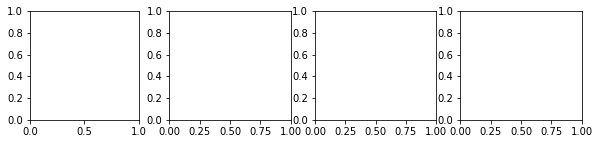

In [38]:
# downlaod and display some example images
# fl = ['https://raw.githubusercontent.com/W281/fileRepository/main/live_session/cat1.png',
#       'https://raw.githubusercontent.com/W281/fileRepository/main/live_session/cat2.png',
#       'https://raw.githubusercontent.com/W281/fileRepository/main/live_session/dog1.png']

fl = ['Data/train/normal/6 - Copy (3).png',
      'Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/000061.png',
      'Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000002.png',
      'Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000003.png']

# img1_n = plt.imread(fl[0])
# img2_a = plt.imread(fl[1])
# img3_l = plt.imread(fl[2])
# img4_s = plt.imread(fl[3])

img1_n = read_image(fl[0])
img2_a = read_image(fl[1])
img3_l = read_image(fl[2])
img4_s = read_image(fl[3])

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10,2))
ax[0].imshow(img1_n)
ax[1].imshow(img2_a)
ax[2].imshow(img3_l)
ax[3].imshow(img4_s)

for axi in ax:
  axi.set_xticks([])
  axi.set_yticks([])
plt.show()

In [33]:
# put the model in evaluation mode
resnet101.eval()
# extract the embeddings for the three images
emb1 = model_conv_features(img1_n.unsqueeze(0).to('cpu')).squeeze()
print(emb1.shape)
emb2 = model_conv_features(img2_a.unsqueeze(0).to('cpu')).squeeze()
print(emb2.shape)
emb3 = model_conv_features(img3_l.unsqueeze(0).to('cpu')).squeeze()
print(emb3.shape)
emb4 = model_conv_features(img4_s.unsqueeze(0).to('cpu')).squeeze()
print(emb4.shape)

AttributeError: 'numpy.ndarray' object has no attribute 'unsqueeze'

In [23]:
# get the cosine similarity between the images
cos = nn.CosineSimilarity(dim=1, eps=1e-6)

cat_cat_sim = cos(emb1_cat.unsqueeze(0), emb2_cat.unsqueeze(0))
print('\n Simlarity between cat images: {0:.4}\n'.format(cat_cat_sim.detach().numpy()[0]))

cat_dog_sim = cos(emb1_cat.unsqueeze(0), emb1_dog.unsqueeze(0))
print('\n Simlarity between cat and dog images: {0:.4}\n'.format(cat_dog_sim.detach().numpy()[0]))


 Simlarity between cat images: 0.7034


 Simlarity between cat and dog images: 0.6018

